# Assingment 3: Shaikspear Generator

## Introduction

Your task is to build a transformer model from scratch and train it on Shakespeare's works. By the end of this assignment, you'll implement the core concepts behind transformers - the architecture that powers modern language models like GPT, BERT, and many others.

### Overview of Transformer Architecture

Transformers revolutionized natural language processing by introducing the self-attention mechanism, which allows the model to process all positions in a sequence simultaneously, rather than sequentially like RNNs. The key innovations include:

1. **Self-Attention**: Allows each position to attend to all positions in the previous layer
2. **Multi-Head Attention**: Runs multiple attention operations in parallel
3. **Positional Encoding**: Adds information about the position of tokens in the sequence
4. **Feed-Forward Networks**: Processes the attended features
5. **Layer Normalization**: Stabilizes training of deep networks
6. **Residual Connections**: Helps with gradient flow in deep networks

### What We're Building

We'll implement a simplified GPT2-style (decoder-only) transformer that can:
- Take a sequence of Shakespeare text as input
- Predict the next character or word in the sequence
- Generate new text in Shakespeare's style

Let's begin by setting up our environment and loading the Shakespeare dataset!

## Your Tasks

Complete all the **TODO** sections in the provided code to build a working transformer model that can generate Shakespeare-style text.

### Step-by-Step Instructions

#### 1. **Read and Understand First** 
- **Before coding anything**, carefully read through the entire notebook
- Pay special attention to the explanatory sections that describe:
  - How transformers work
  - The difference between encoder and decoder architectures
  - The role of attention mechanisms
  - Why we use masking in decoder blocks

#### 2. **Complete the TODO Tasks in Order**

**TODO 1: Character Tokenizer** (`CharacterTokenizer` class)
- Implement character-to-index and index-to-character mappings
- Create `encode()` and `decode()` methods
- Test your tokenizer works correctly

**TODO 2: Dataset Preparation** 
- Convert text to tensor format
- Understand the input-target relationship for next-token prediction

**TODO 3: Dataset Class** (`ShakespeareDataset`)
- Implement `__getitem__()` method to generate training sequences
- Ensure proper input-target shifting (input: "To be or", target: "o be or ")

**TODO 4: Multi-Layer Perceptron** (`Mlp` class)
- Build a simple feed-forward network
- Use GELU activation and proper dimensions (embed_size → 4*embed_size → embed_size)

**TODO 5: Self-Attention Block** (`SelfAttentionBlock`)
- **This is the most complex part** - implement the complete attention mechanism:
  - Generate Query, Key, Value matrices
  - Reshape for multi-head processing
  - Compute attention scores and apply causal masking
  - Apply softmax and combine with values
  - Concatenate multi-head results and project output
- Follow the detailed step-by-step guide provided in the comments

**TODO 6: Transformer Block** (`Block` class)
- Combine attention and MLP with residual connections
- Apply layer normalization correctly

**TODO 7: Full GPT-2 Model** (`GPT2` class)
- Implement the complete forward pass
- Combine token embeddings, positional embeddings, transformer blocks, and output projection
- Handle loss computation for training

**TODO 8: Text Generation Pipeline** (`pipeline` function)
- Implement top-k sampling for text generation
- Handle autoregressive generation (one token at a time)

# 3. **Explain your code**
- After completing each section, write in a markdown section with an explanation of how your code works and why you made certain design choices


### Success Criteria

You'll know you're successful when:
- [ ] All TODO sections are completed without errors
- [ ] The model trains successfully (loss decreases over time)
- [ ] Generated text resembles Shakespeare's style (Dont expect perfection, It should be english text with some Shakespearean flair, probably with some nonsense or non coherent phrases)
- [ ] You can explain how each component works

### 💡 Learning Goals

By the end of this assignment, you should understand:
- How transformers process sequential data
- The role of attention in capturing relationships between tokens
- Why masking is crucial for autoregressive models
- How modern language models generate text
- The architecture behind models like GPT, Claude, and ChatGPT

Remember: This assignment is about understanding, not just completing code. Take your time to read and comprehend each section before implementing the TODOs.

In [ ]:
# imports
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import numpy as np
from collections import Counter, deque
from torch.utils.tensorboard import SummaryWriter
torch.manual_seed(42)

## Load  shakespeare.text file

In [3]:
f_name = 'shakespeare.txt' # if the file in different location, change this line
with open('shakespeare.txt', "r") as f:
    text = f.read()

print(f"Length of text: {len(text)} characters")
print(f"Number of unique characters: {len(set(text))}")
print(f"First 100 characters:\n{text[:100]}")

Length of text: 5436475 characters
Number of unique characters: 84
First 100 characters:
  From fairest creatures we desire increase,
  That thereby beauty's rose might never die,
  But as 


## Data Preparation

# Dataset Encoding and Tokenization

## Understanding Text Encoding for Transformers

Before we can feed text into our transformer model, we need to convert it into numerical representations. This process involves:
1. **Tokenization**: Breaking text into smaller units (characters, subwords, or words)
2. **Vocabulary Building**: Creating a mapping between tokens and unique integers
3. **Encoding**: Converting text sequences into sequences of integers
4. **Decoding**: Converting integer sequences back to readable text

### Character-Level vs Word-Level Tokenization

For this assignment, we'll use **character-level tokenization** 


Let's create a simple character-level tokenizer:



In [7]:
class CharacterTokenizer:
    def __init__(self, text):
        """
        Initialize tokenizer by building vocabulary from input text.
        
        Args:
            text: String containing all training text
        """
        # Get all unique characters and sort them
        self.chars = sorted(list(set(text)))
        self.vocab_size = len(self.chars)
        
        mapping_list = list(enumerate(self.chars))
        self.char_to_index = {char: index for index, char in mapping_list}
        self.index_to_char = {index: char for index, char in mapping_list}

    
    def encode(self, text):
        """Convert string to list of integers"""
        return [self.char_to_index[char] for char in text]
    
    def decode(self, indices):
        """Convert list of integers back to string"""
        return ''.join([self.index_to_char[index] for index in indices])
    
    def __len__(self):
        """Return the size of the vocabulary"""
        return self.vocab_size

# Assuming your text is loaded in a variable called 'text'
# Create the tokenizer
tokenizer = CharacterTokenizer(text)

# Test encoding and decoding
sample_text = "To be or not to be"
encoded = tokenizer.encode(sample_text)
decoded = tokenizer.decode(encoded)

print("Tokenizer vocab_size:", len(tokenizer))
print(f"Original: {sample_text}")
print(f"Encoded: {encoded}")
print(f"Decoded: {decoded}")




Tokenizer vocab_size: 84
Original: To be or not to be
Encoded: [45, 70, 1, 57, 60, 1, 70, 73, 1, 69, 70, 75, 1, 75, 70, 1, 57, 60]
Decoded: To be or not to be


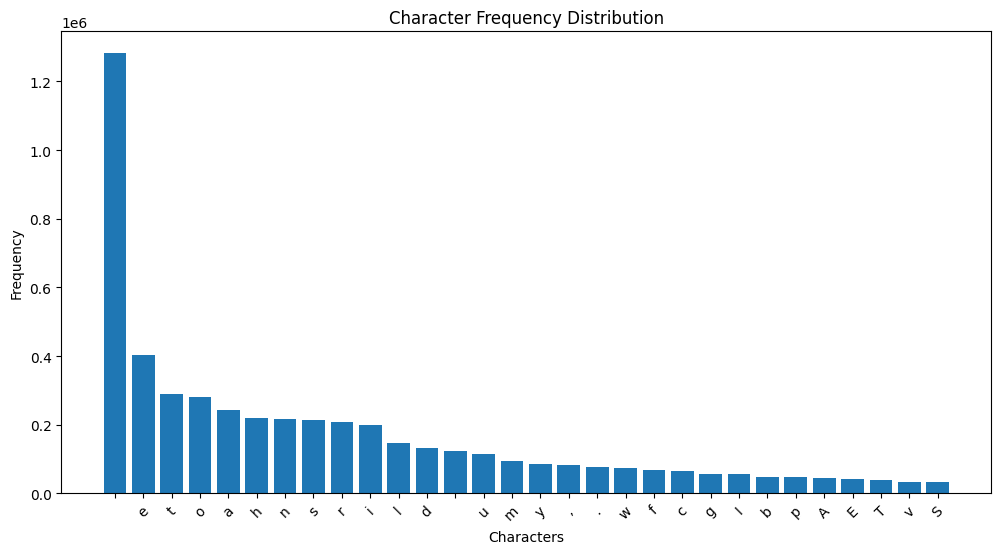

In [8]:
# plot the distribution of character frequencies
char_counts = Counter(text)
def plot_char_distribution(char_counts):
    """Plot the distribution of character frequencies."""
    chars, counts = zip(*char_counts.most_common(30))  # Get top 30 characters
    plt.figure(figsize=(12, 6))
    plt.bar(chars, counts)
    plt.xlabel('Characters')
    plt.ylabel('Frequency')
    plt.title('Character Frequency Distribution')
    plt.xticks(rotation=45)
    plt.show()
plot_char_distribution(char_counts)




Now let's prepare our dataset for training:

In [9]:
import torch

## TODO: Create a torch tensor from the encoded text
data = torch.tensor(tokenizer.encode(text), dtype=torch.long)

print(f"Dataset shape: {data.shape}")

# Split into train and validation sets (90/10 split)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

print(f"Training set size: {len(train_data):,} characters")
print(f"Validation set size: {len(val_data):,} characters")


Dataset shape: torch.Size([5436475])
Training set size: 4,892,827 characters
Validation set size: 543,648 characters


# Understanding Sequence Generation in Transformers

## What is a Transformer Trained to Do?

At its core, a transformer language model is trained to perform **next-token prediction**. This simple objective - predicting what comes next - enables the model to generate coherent text, understand language patterns, and even appear to "understand" context.

### The Autoregressive Nature of Language Modeling

Transformers for text generation are **autoregressive**, meaning they generate text one token at a time, using previously generated tokens as context for predicting the next one.

```
Given: "To be or not to"
Predict: "be" (next token)

Given: "To be or not to be"  
Predict: "," (next token)

Given: "To be or not to be,"
Predict: "that" (next token)
```

### Training vs Generation: Two Different Processes

#### During Training (Assume not a character-level tokenizer for simplicity....)
```python
# Training sees the full correct sequence
Input:  ["To", "be", "or", "not", "to", "be", ",", "that"]
Target: ["be", "or", "not", "to", "be", ",", "that", "is"]

# The model learns in parallel:
Position 0: Given "To" → predict "be"
Position 1: Given "To be" → predict "or"
Position 2: Given "To be or" → predict "not"
... (all positions simultaneously)
```

#### During Generation (Autoregressive)
```python
# Generation builds up token by token
Step 1: Input: "To" → Model predicts: "be"
Step 2: Input: "To be" → Model predicts: "or"  
Step 3: Input: "To be or" → Model predicts: "not"
... (sequential generation)
```

### The Probability Distribution

At each step, the transformer doesn't just predict one token - it outputs a **probability distribution** over the entire vocabulary:

```python
# Example output probabilities after "To be or not to"
{
    "be": 0.7,      # High probability - this phrase often repeats
    "die": 0.1,     # Possible alternative
    "sleep": 0.05,  # Another thematic alternative
    "live": 0.03,   # Less likely but possible
    ",": 0.02,      # Could end the phrase here
    ... (probabilities for all tokens in vocabulary)
}
```



### Context Window and Attention

The transformer's **context window** (block_size) determines how much previous text it can "see" when making predictions:

### What the Model Actually Learns

Through next-token prediction, the transformer learns:

1. **Syntax and Grammar**
   - "To be or" → likely followed by "not"
   - Verb conjugations, sentence structure

2. **Semantic Relationships**
   - "king" often appears near "queen", "throne", "crown"
   - Thematic consistency within passages

3. **Style and Register**
   - Shakespearean vocabulary and phrasing
   - Iambic pentameter patterns
   - Archaic grammatical structures

4. **Long-range Dependencies**
   - Rhyme schemes across lines
   - Character names and relationships
   - Plot consistency



In this assinigment, we train the model to predict the next character given the previous characters:
- **Input**: "To be or"
- **Target**: "o be or "
In the above exmpale there are 8 trainig examples:
1. 'T' -> 'o'
2. 'To' -> ' '
3. 'To ' -> 'b'
4. 'To b' -> 'e'
5. 'To be' -> ' '
6. 'To be o' -> 'r'
8. 'To be or' -> ' '

Pay attention that the transformer will process all of them simultaneously, allowing it to learn the relationships between characters and their positions in the sequence. Also notice how the target is shifted by one position. This teaches the model to predict what comes next.

Lets create a torch Dataset that generates these input-target pairs from our text data.

In [14]:
class ShakespeareDataset(Dataset):
    """
    PyTorch Dataset for Shakespeare text data.
    Generates overlapping sequences for language modeling.
    """
    
    def __init__(self, data, block_size):
        """
        Args:
            data: Tensor of encoded text tokens
            block_size: Length of each sequence (context length)
        """
        self.data = data
        self.block_size = block_size
        
        # Calculate number of possible sequences
        self.num_sequences = len(data) - block_size
        
        if self.num_sequences <= 0:
            raise ValueError(f"Data length ({len(data)}) must be greater than block_size ({block_size})")
    
    def __len__(self):
        """Return the number of possible sequences"""
        return self.num_sequences
    
    def __getitem__(self, idx):
        """
        Get a single sequence and its target.
        
        Args:
            idx: Index of the sequence start position
            
        Returns:
            tuple: (input_sequence, target_sequence)
        """
        # Extract input sequence of length block_size starting at idx
        input_sequence = self.data[idx:idx + self.block_size]
        
        # Extract target sequence (shifted by 1 position)
        target_sequence = self.data[idx + 1:idx + self.block_size + 1]
        
        return input_sequence, target_sequence

###  Explanation: 

The getitem cant go out of bounds because how the dataloader of pytourch is implemented. the __len_ ensure that only valid idx will be provided to the getitem method. 

### Example Dataset Class

In [25]:
num_workers = 2
shuffle_train = True
block_size = 128
batch_size = 16
train_dataset = ShakespeareDataset(train_data, block_size)
val_dataset = ShakespeareDataset(val_data, block_size)

print(f"Training sequences available: {len(train_dataset):,}")
print(f"Validation sequences available: {len(val_dataset):,}")
print("=" * 50)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=shuffle_train,
    num_workers=num_workers,
    drop_last=True  # Drop last incomplete batch for consistent batch sizes
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,  # Don't shuffle validation data
    num_workers=num_workers,
    drop_last=False
)

x, y = next(iter(train_loader))
print("Example of a training batch instance:", end='\n\n')
print(f"Input:'{tokenizer.decode(x[0].tolist())}'") # Decode the first input sequence
print("=" * 50)
print(f"Target:'{tokenizer.decode(y[0].tolist())}'") # Decode the first target sequence

Training sequences available: 4,892,699
Validation sequences available: 543,520
Example of a training batch instance:

Input:'n
  Ne'er brake into extremity of rage.
ABBESS. Hath he not lost much wealth by wreck of sea?
  Buried some dear friend? Hath no'
Target:'
  Ne'er brake into extremity of rage.
ABBESS. Hath he not lost much wealth by wreck of sea?
  Buried some dear friend? Hath not'


## Transformer Architecture Overview
The transformer is a neural network architecture that revolutionized how AI systems process language. Think of it as a sophisticated pattern-matching system that can understand relationships between words in a sentence, regardless of how far apart they are.

**The Core Innovation: Attention**

The transformer's key breakthrough is something called "attention." Instead of reading text word-by-word like older systems, transformers look at all words simultaneously and figure out which ones are most relevant to each other. It's like having a conversation where you can instantly consider every word someone has said, not just the most recent ones.

**Types of Attention Mechanisms**

There are three main types of attention used in transformers:

- **Self-Attention(Bidirectional)**: Each position in a sequence attends to all positions in the same sequence. This is like each word asking "which other words in this sentence are most relevant to understanding me?"

- **Cross-Attention**: Positions in one sequence (like a decoder) attend to positions in a different sequence (like an encoder). This is used in encoder-decoder models where the decoder needs to "look at" the encoder's representations while generating output.

- **Masked Self-Attention**: A restricted form of self-attention where each position can only attend to previous positions, not future ones. This maintains the causal structure needed for text generation.

**How Masking Controls Encoder vs Decoder Behavior**

The key difference between encoder and decoder blocks lies in their attention masking:

- **Encoder blocks** use **bidirectional self-attention** with no masking. Each token can attend to all other tokens in the sequence, allowing the model to build rich contextual representations by considering the full context.

- **Decoder blocks** use **causal masking** (also called autoregressive masking). Each token can only attend to itself and previous tokens, never future ones. This prevents the model from "cheating" during training by looking ahead, forcing it to learn to predict the next token based only on what came before.

**How It Works**

The original transformer has two main parts:
- **Encoder**: Takes input text and creates rich representations that capture meaning and context using bidirectional attention
- **Decoder**: Uses those representations and generates output text using causal attention plus cross-attention to the encoder

Both parts use "self-attention" layers that let each word position "attend to" or focus on other positions. This creates a web of connections showing which words are most important for understanding each other.

**Modern Simplification: Decoder-Only Architecture**

However, for many real-world applications, researchers discovered that using only the decoder portion is often sufficient and more efficient. This **decoder-only** approach is what powers popular language models like GPT, Claude, and most modern conversational AI systems. Instead of having separate encoder and decoder stacks, these models use multiple decoder blocks that generate text autoregressively - predicting one token at a time based on all previous tokens using causal masking. This is the architecture we'll be building in this notebook.

**Key Components**

- **Multi-head attention**: Instead of just one attention mechanism, it runs several in parallel, each potentially focusing on different types of relationships
- **Feed-forward networks**: Simple neural networks that process the attention outputs
- **Layer normalization and residual connections**: Technical elements that help training stability
- **Positional encoding**: Since attention doesn't inherently understand word order, this adds position information

**Why It Matters**

Transformers can process text in parallel rather than sequentially, making them much faster to train. They're also better at capturing long-range dependencies - understanding how a word at the beginning of a paragraph relates to one at the end. The decoder-only variant proves particularly effective for text generation tasks, as it learns to model the probability distribution of natural language through next-token prediction. The masking mechanism is crucial here - it ensures the model learns proper causal relationships and can generate coherent text without access to future information. This architecture powers modern language models like GPT, BERT, and others that have transformed natural language processing.

<img src="https://heidloff.net/assets/img/2023/02/transformers.png">

### Feed-Forward Network (MLP)
Lets start from from simple to complicated. As the diagram shows, the MLP is a simple feed-forward neural network that processes the output of the attention mechanism. In the GPT2 architecture that we are following here it consists of two linear transformations with a GeLU activation in between. The MLp layer streach the dimention of the embedding from `embed_size` to `4*embed_size` and then back to `embed_size`.
```python

### MLP

In [35]:
class Mlp(nn.Module):
    """
    A simple MLP with two linear layers and GELU activation.
    First layer: embed_size -> 4 * embed_size
    Second layer: 4 * embed_size -> embed_size
    GELU activation between the two layers
    """
    def __init__(self, config):
        super(Mlp, self).__init__()
        self.embed_size = config.embed_size
        self.layer_one = nn.Linear(self.embed_size, 4 * self.embed_size)
        self.layer_two = nn.Linear(4 * self.embed_size, self.embed_size)
        self.gelu = nn.GELU()
        
    def forward(self, x):
        x = self.layer_one(x)
        x = self.gelu(x)
        x = self.layer_two(x)
        return x

## Multi Head Masked Self-Attention Implementation

The self-attention mechanism is the core of the transformer architecture, allowing the model to weigh the importance of different words in a sequence relative to each other. This guide walks you through completing the provided implementation.

### Understanding the Provided Setup

You're given a `SelfAttentionBlock` class with the initialization already complete. Here's what's provided:

**Linear Layers**:
- `self.c_atten`: Creates Q, K, V matrices simultaneously (outputs `3 * head_size * num_heads`)
- `self.c_proj`: Final output projection back to embedding size

**Causal Mask**: 
- `self.bias`: Pre-computed lower triangular mask of shape `(1, 1, block_size, block_size)`
- Prevents attending to future positions (essential for decoder behavior)

**Key Constraint**: `head_size * num_heads = embed_size` (this is verified in the assertion)


### Step-by-Step Implementation

1. **Input Processing**: Your input tensor `x` has shape `(B, T, C)` where:
   - `B` = batch size (number of sequences processed together)
   - `T` = sequence length (number of tokens in each sequence)  
   - `C` = embedding size (dimension of each token's representation)

2. **Generate Q, K, V Matrices**: 
   - Apply linear transformation: `kqv = self.linear_layer(x)`
   - Output shape: `(B, T, 3 * embed_size)`
   - Split into three equal parts: `k, q, v = kqv.split(embed_size, dim=2)`
   - Each tensor now has shape: `(B, T, embed_size)`

3. **Reshape for Multi-Head Attention**: Transform each tensor to separate the attention heads:
   - Reshape `k, q, v` tensors: `(B, T, embed_size)` → `(B, T, num_heads, head_size)`
   - Transpose dimensions: `(B, T, num_heads, head_size)` → `(B, num_heads, T, head_size)`
   - This allows processing all heads in parallel

4. **Compute Attention Scores**: Calculate how much each position should attend to others:
   - Matrix multiply queries and keys: `scores = q @ k.transpose(-2, -1)`
   - Scale by head dimension: `scores = scores / sqrt(head_size)`
   - Result shape: `(B, num_heads, T, T)` - each position has scores for all positions

5. **Apply Causal Masking**: Prevent attending to future positions:
   - Set future positions to negative infinity: `scores.masked_fill(self.mask == 0, float('-inf'))`
   - This ensures softmax gives zero probability to future positions

6. **Convert to Probabilities**: Apply softmax to get attention weights:
   - `attention_weights = softmax(scores, dim=-1)`
   - Shape remains: `(B, num_heads, T, T)`
   - Each row now sums to 1.0

7. **Apply Attention to Values**: Use weights to combine value vectors:
   - `output = attention_weights @ v`
   - Output shape: `(B, num_heads, T, head_size)`

8. **Concatenate Multi-Head Results**: Combine all attention heads:
   - Transpose back: `(B, num_heads, T, head_size)` → `(B, T, num_heads, head_size)`
   - Reshape to flatten heads: `(B, T, num_heads, head_size)` → `(B, T, embed_size)`
   - Ensure tensor is contiguous in memory before reshaping

9. **Final Output Projection**: Apply final linear transformation:
   - `final_output = self.output_projection(concatenated_output)`
   - Input and output both have shape: `(B, T, embed_size)`

### Key Implementation Details

**Dimension Tracking**: Always verify your tensor shapes at each step. The most common bugs come from incorrect reshaping or matrix multiplication dimensions.

**Memory Layout**: Use `.contiguous()` before reshaping operations to ensure proper memory layout.

**Masking Strategy**: Pre-compute your causal mask during initialization and store it as a buffer to avoid recomputing it every forward pass.

**Scaling Factor**: The `1/sqrt(head_size)` scaling prevents attention scores from becoming too large, which would make gradients vanish after softmax.

**Efficient Computation**: Modern frameworks often provide optimized attention functions (like `scaled_dot_product_attention`) that handle steps 4-7 efficiently, but understanding the manual implementation helps you debug and customize the mechanism.

In [37]:
import math


class SelfAttentionBlock(nn.Module):
    def __init__(self, config):
        super(SelfAttentionBlock, self).__init__()
        assert config.embed_size % config.num_heads == 0
        
        # self-attention values (key, query, value). pay attention that head_size * num_heads must be equal to embed_size
        self.c_atten = nn.Linear(config.embed_size, 3*config.embed_size) # multiply by 3 to get k, q, v
        
        # output projection
        self.c_proj = nn.Linear(config.embed_size, config.embed_size)
        
        self.embed_size = config.embed_size
        self.num_heads = config.num_heads

        mask = torch.tril(torch.ones(config.block_size, config.block_size)) # Lower triangular mask for causal attention
        mask = mask.view(1, 1, config.block_size, config.block_size) # B, 1, T, T
        self.register_buffer('mask', mask)  # register_buffer allows the mask to be part of the model state but not a parameter to optimize
        
    def forward(self, x):
        #  after each line print the shape of x
        """        Forward pass for the self-attention block.
        Args:
            x: Input tensor of shape (B, T, C) where B is batch size, T is sequence length, C is embedding size
        Returns:
            out: Output tensor of shape (B, T, C) after self-attention and projection
        """
        B, T, C = x.shape # Batch, sequence length, embed_size
        if C != self.embed_size:
            raise ValueError(f"Input embedding size {C} does not match expected embedding size {self.embed_size}")
        
        k, q, v = self.c_atten(x).split(self.embed_size, dim=2) # split the output into k, q, v.  Each is of shape (B, T, embed_size)
        head_size = self.embed_size // self.num_heads

        # reshape k, q, v to (B, T, num_heads, head_size). As embed_size == num_heads * head_size, we can do this by dividing embed_size by num_heads
        k = k.view(B, T, self.num_heads, head_size)
        q = q.view(B, T, self.num_heads, head_size)
        v = v.view(B, T, self.num_heads, head_size)

        # transpose k, q, v to (B, num_heads, T, head_size) 
        k = k.transpose(1, 2)
        q = q.transpose(1, 2)
        v = v.transpose(1, 2)

        # compute attention scores
        att_scores = (q @ k.transpose(-2, -1))
        att_scores = att_scores / math.sqrt(head_size) # scale the attention scores
        att_scores = att_scores.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf')) # mask the attention scores
        
        # calculte the attention weights
        att_weights = F.softmax(att_scores, dim=-1) # shape (B, num_heads, T, T)

        # compute the output
        output = att_weights @ v # shape (B, num_heads, T, head_size)

        # concatenate the output of the heads
        concatenated_output = output.transpose(1, 2).contiguous().view(B, T, C) # shape (B, T, C)

        # project the output to the embed_size
        final_output = self.c_proj(concatenated_output)

        return final_output # shape (B, T, embed_size)




## Transformer Block

The transformer block is a single layer containing two main components: **Multi-Head Attention** followed by **MLP (Multi-Layer Perceptron)**. This layer design gets stacked multiple times to create the full transformer.

### Layer Structure

**Multi-Head Attention Layer**: Allows each position to gather information from other positions in the sequence. Multiple attention heads work in parallel, each potentially focusing on different types of relationships.

**MLP Layer**: Processes each position independently through a feed-forward network, applying learned transformations to refine the representations.

### Residual Connections - The Critical Bridge

**What Residual Connections Are**: Instead of just passing the output forward, you add the original input back to the output: `output = input + layer(input)`. This creates a direct path for information to flow unchanged.

**Why Residual Connections Are Essential**:
- **Gradient Flow**: In deep networks, gradients can vanish as they backpropagate through many layers. Residuals provide direct gradient highways.
- **Identity Preservation**: The network can learn to keep useful information unchanged by making the layer output close to zero.
- **Easier Learning**: The layer only needs to learn the "difference" or "refinement" rather than completely new representations.
- **Stable Training**: Without residuals, very deep transformers become difficult or impossible to train.

### Layer-by-Layer Processing

**First Layer - Multi-Head Attention**:
1. Normalize the input
2. Apply multi-head attention to capture inter-position relationships  
3. Add the original input back (residual connection)

**Second Layer - MLP**:
1. Normalize the current representations
2. Apply feed-forward transformations to each position
3. Add the pre-MLP representations back (residual connection)

The residual connections ensure that even in a 50-layer transformer, information and gradients can flow directly from the first layer to the last, enabling the training of very deep and powerful models.

In [28]:
class Block(nn.Module):
    def __init__(self, config):
        super(Block, self).__init__()
        self.ln1 = nn.LayerNorm(config.embed_size)
        self.ln2 = nn.LayerNorm(config.embed_size)
        self.mlp = Mlp(config)
        self.self_attn = SelfAttentionBlock(config)
        
    def forward(self, x):
        normalized_x = self.ln1(x)
        multi_head_attn = self.self_attn(normalized_x)
        x = x + multi_head_attn
        normalized_x = self.ln2(x)
        mlp_output = self.mlp(normalized_x)
        x = x + mlp_output
        return x
    

## Transformer Model


The `GPT2` class represents the complete transformer model - a decoder-only architecture that processes text and predicts the next token. This is the full model that combines all the components you've built.

### Model Architecture Overview

**Embedding Layers**: Convert discrete tokens into continuous vector representations that the neural network can process.

**Transformer Stack**: Multiple transformer blocks stacked together, each refining the representations further.

**Output Layer**: Converts the final representations back to vocabulary predictions for next-token generation.

### Core Components

**Token Embedding (`wte`)**: Maps each vocabulary word to a learned vector representation. Transforms token IDs into dense embeddings of size `embed_size`.

**Position Embedding (`wpe`)**: Adds positional information since attention doesn't inherently understand word order. Each position gets its own learned embedding.

**Transformer Blocks**: Stack of identical blocks (typically 12-48 layers) that progressively refine the representations through attention and feed-forward processing.

**Final Layer Norm (`ln_f`)**: Normalizes the output from all transformer blocks before making predictions.

**Language Model Head (`lm_head`)**: Linear layer that converts final embeddings back to vocabulary logits for next-token prediction.

### Forward Pass Flow

**Input Processing**:
1. Convert token IDs to embeddings
2. Add positional embeddings to provide sequence order information
3. Combine token and position embeddings element-wise

**Transformer Processing**:
- Pass through each transformer block sequentially
- Each block applies attention and MLP with residual connections
- Representations become increasingly sophisticated through the stack

**Output Generation**:
1. Apply final normalization to stabilize outputs
2. Project to vocabulary size using the language model head
3. Compute loss against targets if provided for training

### Key Design Decisions

**Weight Sharing**: The token embedding and output projection share the same weights, reducing parameters and creating symmetry between input and output representations.

**Autoregressive Training**: During training, the model predicts each position based only on previous positions, learning the sequential nature of language.

**Next-Token Prediction**: The fundamental task is predicting the probability distribution over the vocabulary for what token should come next at each position.

This architecture enables the model to generate coherent text by learning statistical patterns in language through the simple but powerful objective of next-token prediction.

In [29]:
class GPT2(nn.Module):
    def __init__(self, config):
        super(GPT2, self).__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.embed_size), # token embeddings
            wpe = nn.Embedding(config.max_len, config.embed_size), # positional embeddings
            blocks = nn.ModuleList([Block(config) for _ in range(config.num_layers)]), # transformer blocks
            ln_f = nn.LayerNorm(config.embed_size)
            )
        )
        self.lm_head = nn.Linear(config.embed_size, config.vocab_size) # output layer for next token prediction

        # sharing weights between token embedding and output layer
        self.transformer.wte.weight = self.lm_head.weight # this allows the model to use the same embeddings for input and output tokens
        
    def forward(self, idx, target=None):
        """ Forward pass of the GPT-2 model.
        Args:            idx: Input tensor of shape (B, T) where B is batch size and T is sequence length
            target: Optional target tensor of shape (B, T) for computing loss
        Returns:            logits: Output tensor of shape (B, T, vocab_size) containing logits for next token
            loss: Optional scalar loss value if target is provided
        """
        B, T = idx.shape
        assert T <= self.config.block_size, f"Input tokens length {T} exceeds maximum length {self.config.block_size}"
        
        # TODO: Implement the forward pass of the GPT-2 model. 
        
        return logits, loss

    def save_model(self, path):
        torch.save(self.state_dict(), path)
    
    def load_model(self, path):
        self.load_state_dict(torch.load(path))
            

## Text Generation


### Sampling Strategies

How we convert these probabilities into actual text generation:

#### 1. Greedy Decoding
```python
# Always pick the highest probability token
def greedy_sample(logits):
    return torch.argmax(logits, dim=-1)

# Result: Deterministic but potentially repetitive
```

#### 2. Temperature Sampling
```python
# Control randomness with temperature
def temperature_sample(logits, temperature=0.8):
    # Higher temperature = more random
    # Lower temperature = more focused
    scaled_logits = logits / temperature
    probs = torch.softmax(scaled_logits, dim=-1)
    return torch.multinomial(probs, num_samples=1)

# Temperature effects:
# T=0.1: "To be or not to be, that is the question"  (very predictable)
# T=0.8: "To be or not to be, that troubles the mind"  (creative but coherent)
# T=2.0: "To be or not to fish, purple dreams loudly"  (too random)
```

#### 3. Top-k Sampling
```python
# Only consider the k most likely tokens
def top_k_sample(logits, k=50):
    values, indices = torch.topk(logits, k)
    probs = torch.softmax(values, dim=-1)
    next_token = torch.multinomial(probs, num_samples=1)
    return indices[next_token]
```

Implement a top-k sampling  function to generate text from the model.



In [30]:
def pipeline(model, tokenizer, k=10):
    """    Create a text generation pipeline for the given model and tokenizer.
    Args:
        model: The trained model instance
        tokenizer: The tokenizer instance
        k: Number of top-k tokens to sample from at each step (default: 10)
    Returns:A function that takes a prompt and generates text"""
    # step-by-step explanation of the pipeline function:
    """
    1. Set the model to evaluation mode
    2. Encode the input prompt using the tokenizer
    3. Convert the encoded prompt to a tensor and move it to the model's device
    4. While the length of the generated sequence is less than max_len:
        a. Get the model's logits for the last token in the sequence
        b. Extract the logits for the last token and apply softmax to get probabilities
        v. Use top-k sampling to select the next token based on probabilities
        d. Append the selected token to the sequence
    5. Decode the generated sequence back to text using the tokenizer
    6. Return the generated text
    """
    def generate(prompt, max_len=1024):
        ## TODO: Implement the pipeline function
        pass
    return generate


# exmple usage of the pipeline
"""
generate_text = pipeline(model, tokenizer)
prompt = "To be or not to be, that is the question: "
generated_text = generate_text(prompt, max_len=100)
"""


'\ngenerate_text = pipeline(model, tokenizer)\nprompt = "To be or not to be, that is the question: "\ngenerated_text = generate_text(prompt, max_len=100)\n'

### Conig the Transformer Model

In [31]:
# This is the most minmal config class for GPT-2 (Takes 40-60 to train). You are welcome to modify it to a bigger model or for loger but no the other way around (expet of batch size which you can reduce if you run out of memory)
class GPT2Config:
    def __init__(self):
        self.embed_size = 64
        self.num_heads = 2
        self.num_layers = 4
        self.vocab_size = len(tokenizer)
        self.block_size = 256
        self.lr = 3e-4
        self.batch_size = 32 # use a smaller batch size if you run out of memory
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.path = 'models/model.pth'
        self.num_epochs = 10

        self.patience = 5  # Early stopping patience
        self.grad_clip = 1.0  # Gradient clipping threshold
        
        # Learning rate scheduler configs
        self.use_scheduler = True
        self.scheduler_type = 'reduce_on_plateau'  # 'reduce_on_plateau', 'cosine', 'step'
        self.lr_patience = 2  # For ReduceLROnPlateau
        self.lr_factor = 0.5  # For ReduceLROnPlateau
        self.step_size = 1  # For StepLR
        self.gamma = 0.1  # For StepLR

## Traninig

In [32]:
# traning function
def train_model(model, train_loader, val_loader, optimizer, config=None):

    # Setup
    model.train()
    summary_writer = SummaryWriter(log_dir='runs/shakespeare_experiment')
    
    # Create models directory
    os.makedirs('models', exist_ok=True)
    
    # Training state tracking
    best_val_loss = float('inf')
    patience_counter = 0
    patience = getattr(config, 'patience', 5)  # Early stopping patience
    
    # Loss tracking
    train_losses = deque(maxlen=1000)
    global_step = 0
    
    print("Starting training...")
    print(f"Training for {config.num_epochs} epochs")
    print(f"Training batches: {len(train_loader)}, Validation batches: {len(val_loader)}")
    
    for epoch in range(config.num_epochs):
        print(f"\nEpoch {epoch + 1}/{config.num_epochs}")
        
        # Training phase
        model.train()
        epoch_train_losses = []
        
        with tqdm(train_loader, desc=f"Training Epoch {epoch + 1}") as pbar:
            for batch_idx, (x, y) in enumerate(pbar):
                x, y = x.to(config.device), y.to(config.device)
                
                # Forward pass
                optimizer.zero_grad()
                logits, loss = model(x, y)
                
                # Backward pass
                loss.backward()
                
                # Gradient clipping (optional but recommended)
                if hasattr(config, 'grad_clip') and config.grad_clip > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_clip)
                
                optimizer.step()
                
                # Track losses
                loss_item = loss.item()
                train_losses.append(loss_item)
                epoch_train_losses.append(loss_item)
                
                # Update progress bar
                pbar.set_postfix({
                    'loss': f"{loss_item:.4f}",
                    'avg_loss': f"{np.mean(train_losses):.4f}",
                    'lr': f"{optimizer.param_groups[0]['lr']:.2e}"
                })
                
                # Log to tensorboard every N steps
                if global_step % 10 == 0:  # Log every 10 steps
                    summary_writer.add_scalar('Loss/train_step', loss_item, global_step)
                    summary_writer.add_scalar('Learning_Rate', optimizer.param_groups[0]['lr'], global_step)
                
                global_step += 1
        
        # Validation phase
        model.eval()
        val_losses = []
        
        with torch.no_grad():
            with tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}", leave=False) as val_pbar:
                for x, y in val_loader:
                    x, y = x.to(config.device), y.to(config.device)
                    logits, loss = model(x, y)
                    val_losses.append(loss.item())
                    val_pbar.set_postfix({'val_loss': f"{loss.item():.4f}"})
        
        # Calculate epoch metrics
        avg_train_loss = np.mean(epoch_train_losses)
        avg_val_loss = np.mean(val_losses)
        
        # Log epoch metrics
        summary_writer.add_scalar('Loss/train_epoch', avg_train_loss, epoch)
        summary_writer.add_scalar('Loss/validation_epoch', avg_val_loss, epoch)
        
        print(f"Epoch {epoch + 1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        
        # Model checkpointing
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'global_step': global_step
        }
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(checkpoint, os.path.join('models', 'best_model.pt'))
            print(f"New best model saved! Val loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
        
        # Save regular checkpoint
        torch.save(checkpoint, os.path.join('models', f'checkpoint_epoch_{epoch}.pt'))
        
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered after {patience} epochs without improvement")
            break
        
        # Save latest model using your custom save method
        if hasattr(model, 'save_model'):
            model.save_model(config.path)
    
    # Final logging
    summary_writer.close()
    print("Training complete!")
    print(f"Best validation loss: {best_val_loss:.4f}")
    
    return {
        'best_val_loss': best_val_loss,
        'final_train_loss': avg_train_loss,
        'final_val_loss': avg_val_loss,
        'epochs_trained': epoch + 1
    }

def estimate_loss(model, eval_iters, data_loaders={}):
    """        Estimate the loss of the model on the given splits.
    Args:
        model: The model to evaluate
        eval_iters: Number of iterations to average the loss over
        splits: List of dataset splits to evaluate (e.g., 'train', 'validation')
        data_loader: DataLoader instance for fetching batches
    Returns:
        out: Dictionary with average loss for each split
    """
    with torch.no_grad():
        out = {}
        model.eval()
        for split, dl in data_loaders.items():
            losses = 0
            for i in range(eval_iters):
                x, y = next(iter(dl))
                x, y = x.to(model.config.device), y.to(model.config.device)
                _, loss = model(x, y)
                losses += loss.item()
            out[split] = losses / eval_iters
        model.train()
    return out

In [33]:
# init config and datasets
con = GPT2Config()
train_dataset = ShakespeareDataset(train_data, con.block_size)
val_dataset = ShakespeareDataset(val_data, con.block_size)
train_loader = DataLoader(
    train_dataset,
    batch_size=con.batch_size,
    shuffle=shuffle_train,
    num_workers=4,
    drop_last=True  # Drop last incomplete batch for consistent batch sizes
)

val_loader = DataLoader(
    val_dataset,
    batch_size=con.batch_size,
    shuffle=False,  # Don't shuffle validation data
    num_workers=4,
    drop_last=False
)


model = GPT2(con)
model.to(con.device)
print(f"device: {con.device}")
optimizer = torch.optim.Adam(model.parameters(), lr=con.lr)

total_params = 0
for name, param in model.named_parameters():
    total_params += param.numel()
print(f"Total parameters: {total_params:,}")

AttributeError: 'GPT2Config' object has no attribute 'max_len'

In [ ]:
# Creating an optimizer 
optimizer = torch.optim.AdamW(model.parameters(), lr=con.lr, weight_decay=0.01)

# train the model
results = train_model(model, train_loader, val_loader, optimizer, con)

In [ ]:
generator = pipeline(model, tokenizer, k=10)
print(generator('to be or not to be', max_len=1024)[0])